<a href="https://colab.research.google.com/github/lucagnecchi/Image_classification/blob/main/Breast_cancer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast cancer classification


- Filippo Elmino 5208413
- Luca Gnecchi 5206807

*Source of the dataset*: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

# Goal of the study

Among all types of cancer in women, breast cancer is most likely to occur. Breast cancer has the second highest mortality rate after Lung & Bronchial cancer. For this reason, an early detection it is very important and it can make the difference in saving lives.

Medical image processing is one of the techniques that have been developed to detect breast cancer. Images are acquired by histopathology, which generally includes biopsy of the affected tissue.

Tissues are examined under a microscope. These microscopic images can be collected and used for developing computer-aided detection systems.

The goal is to identify whether a tumor is benign or of a malignant in nature and to classify the different images into 5 categories: benign tumor and the 4 types of malignant tumors ductal carcinoma, lobular carcinoma, mucinous carcinoma, papillary carcinoma.

#Loading libraries

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
!pip install torch torchvision
!pip install d2l==1.0.0a1.post0  # notice the precise version
import torch
from torchvision import transforms, datasets
from torch.utils import data
import torch.nn.functional as F
from torch.utils.data import ConcatDataset
from d2l import torch as d2l
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #connetto questo file colab al mio drive

Mounted at /content/drive


# Data manipulation

First of all we want to perform some **data manipulation** in order to organise the data upon which we will perform our analysis. The data are stored in several folders, at the end of the procedure we want to obtain two folders: **test** and **train** with all the different categories that we are taking into account.

The following code cell contains the code used for moving all the images corresponding to the category *ductal_carcinoma* in the same folder. We repeated the procedure also for the other categories of tumor both *benign* and *malignant*.

In [ ]:
percorso = "/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma"

#we want to store in the list SOB the full path with the subdirectories of
#ductal_carcinoma
SOB = []
#with os.listdir we consider the subdirectories of ductal_carcinoma
for i in os.listdir(percorso):
  #with os.path.join we add the subdirectories to the path: percorso
  SOB.append(os.path.join(percorso, i))

#we repeat the same procedure for the other folders
dir = []

for i in SOB:

  zoom = os.listdir(i)

  for j in range(len(zoom)):

    dir.append(os.path.join(i, zoom[j]))



dir2 = []

for i in dir:
  img  = os.listdir(i)
  for j in range(len(img)):
    dir2.append(os.path.join(i, img[j]))



#finally, with the function shutil.move, we can move each image that has path "i"
#to the folder  saved in "percorso"
#for i in dir2:
  #shutil.move(i, percorso)

Now we are unzipping the file in order to store it in google drive.

In [ ]:
!tar -xzvf 'BreaKHis_v1.tar.gz'

In [ ]:
dataset_path = '/content/drive/MyDrive/Colab\ Notebooks/Progetto\ deep\ learning/BreaKHis_v1/histology_slides/breast'

In [ ]:
subfolders

['/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/benign/SOB/tubular_adenoma',
 '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/benign/SOB/phyllodes_tumor',
 '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/benign/SOB/fibroadenoma',
 '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis']

In [ ]:
for subfolder in subfolders:
    images = [f.path for f in os.scandir(subfolder) if f.is_file() and f.name.endswith(('.jpg', '.jpeg', '.png'))]
    for image in images:
        #shutil.move(image, dataset_path)

In [ ]:
cartella_drive = '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/benign'
os.listdir(cartella_drive)

['SOB',
 'process_db_stat.py',
 'tubular_adenoma.stat.txt',
 'fibroadenoma.stat.txt',
 'README_B.txt',
 'adenosis.stat.txt',
 'phyllodes_tumor.stat.txt']

## Data visualization analysis

Breast Cancer Histopathological Database is composed of approximately 8.000 microscopic images of breast tumor tissue collected using different magnifying factors (40X, 100X, 200X, and 400X). It contains 2,480  benign and 5,429 malignant samples.

They are 700X460 pixels color images in PNG format. For this reason we will use a transform method to convert them into a Pytorch tensor format and to reshape them.

We have also decided to group all the benign images together, otherwise its subcategories would be under represented and they could create noise in our model.

Samples present in this dataset were collected using SOB method (surgical (open) biopsy). This is a type of procedures widely used to collect samples of breast tissues and, compared to any methods of needle biopsy, it can be done in a hospital with general anesthetic.

The following codes of this section are useful only to produce some visual representations of the distribution of our images among the classes and to show some sample images.

In [ ]:
main_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/malignant/SOB'

# Dictionary that will contain all the images. The keys are the 5 labels
all_images = {}


main_folders = ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']

# loop through the different drive folders (one for each category)
for main_folder in main_folders:
    current_folder_path = os.path.join(main_dataset_path, main_folder)

    # List that will contain all the images of the current category
    category_images = []

    # loop through all the images in the folder of the corresponding category
    for image_file in os.listdir(current_folder_path):
        image_path = os.path.join(current_folder_path, image_file)

        # loading the image
        image = Image.open(image_path)

        # Appending the image
        category_images.append(image)

    # save the list of images in the dictionary
    all_images[main_folder] = category_images

# Example of how to access to an image: all_images['tubular_adenoma'][index]

The code above produce a dictionary in which the keys are the 4 categories related to malignant tumors. For each key we save all the images that are associated to it. They were previously grouped into a list called "category_images" thanks to a for loop that iterates over all the images in the corresponding drive folder.

In [ ]:

current_folder_path = '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/benign/SOB'


main_folder='benign'
category_images = []

# loop through all the images in the benign
for image_file in os.listdir(current_folder_path):
    image_path = os.path.join(current_folder_path, image_file)

    #loading the image
    image = Image.open(image_path)

    # Appending the image
    category_images.append(image)

# Add the list of all benign images to the dictionary defined previously
all_images[main_folder] = category_images


The same is done for benign tumors. Here there is a unique class that will be an additional key of the dictionary created before and this key is associated to a list of all benign images.

With the following for loop we want to compute the number of images in each category.

In [ ]:
dim_classes=[]
for key in all_images:
  dim_classes.append(len(all_images[key]))

([<matplotlib.patches.Wedge at 0x7c4558052620>,
 [Text(0.2185352054365133, 1.0780734501808404, 'ductal_carcinoma'),
  Text(-1.087426949338625, 0.16583916863060902, 'lobular_carcinoma'),
  Text(-1.007991657451331, -0.44040074762484116, 'mucinous_carcinoma'),
  Text(-0.6407884532392377, -0.8940862140729301, 'papillary_carcinoma'),
  Text(0.6633364332820164, -0.9999923881113761, 'benign')],
 [Text(0.11920102114718906, 0.5880400637350038, '43.6%'),
  Text(-0.5931419723665227, 0.09045772834396855, '7.9%'),
  Text(-0.5498136313370895, -0.2402185896135497, '10.0%'),
  Text(-0.34952097449412967, -0.48768338949432544, '7.1%'),
  Text(0.38694625274784283, -0.5833288930649694, '31.4%')])

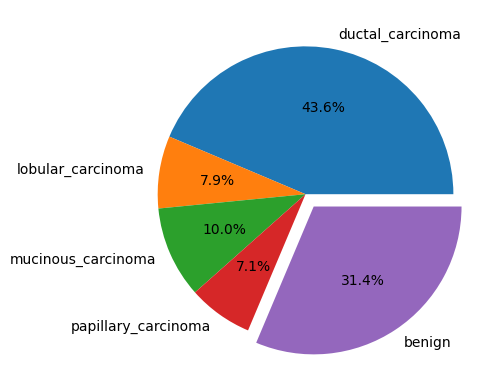

In [ ]:
explode_list = [0, 0, 0, 0, 0.1]
plt.pie(dim_classes,labels=['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma','benign'],autopct='%1.1f%%',explode=explode_list)

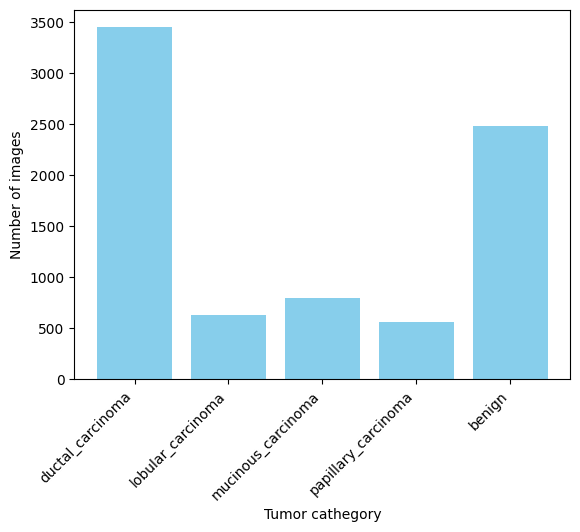

In [ ]:
plt.bar(['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma','benign'], dim_classes, color='skyblue')
plt.xlabel('Tumor cathegory')
plt.ylabel('Number of images')
plt.xticks(rotation=45, ha='right')
plt.show()

The piechart and the barchart aim to show the need to random sample a subset of images among the ones that belongs to ductal carcinoma category. The random sampling will be performed in the next section.

In [ ]:
images_per_category = {}
for key in all_images:
    if key not in images_per_category:
        images_per_category[key] = all_images[key]



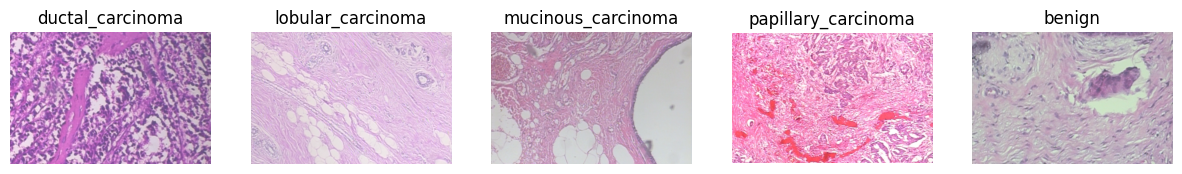

In [ ]:
categories = ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma','benign']
len_categories = len(categories)
#using subplots function we have created 5 axes where we display the first image of each category
fig, axs = plt.subplots(1, len_categories, figsize=(15, 5))

for i, category in enumerate(categories):
    axs[i].imshow(images_per_category[category][0])
    axs[i].set_title(category)
    axs[i].axis('off')

plt.show()

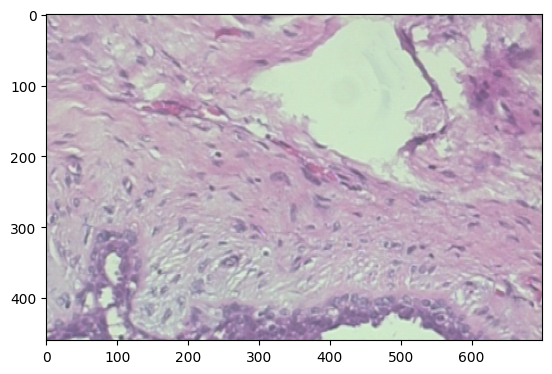

In [ ]:
(all_images['benign'][0])
plt.imshow(all_images['benign'][0])

## Split into train and test set and samplig a subset of the category "ductal carcinoma"

In this section we are splitting the dataset into train and test set, we are considering the 80% of the observations for the train set and the remaining 20% for the test set. As we saw in the previous section, we have that the category *ductal carcinoma* is over represented. For this reason we chose to consider only a subset of the images contained in *ductal carcinoma* folder.

In [ ]:
data_augmentation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [ ]:
import random
import shutil
destination_folder = '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/File spostati'

#'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma','benign'

source_folder = '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/malignant/SOB/ductal_carcinoma'

all_files = os.listdir(source_folder)
n=len(all_files)
files_to_move = random.sample(all_files, n-900)
for file_name in files_to_move:
  source_path = os.path.join(source_folder, file_name)
  destination_path = os.path.join(destination_folder, file_name)
  #shutil.move(source_path, destination_path)

In [ ]:
#this is the number of images in ductal_carcinoma
n


3451

In [ ]:
#this is the number of moved images
len(os.listdir(destination_folder))

2557

Now we can finally split the dataset into train and test. For this purpose we are moving the 20% of the images to the test folder, as in the subsampling for the *ductal carcinoma* category, we random sample the image to move.

In [ ]:
import random
destination_folder = '/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/Test'
categories = ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma','benign']
#'ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma','benign'
for i in categories:
  source_folder = f'/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/malignant/SOB/{i}'
  destination_folder = f'/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/Test/{i}'
  all_files = os.listdir(source_folder)
  n = len(all_files)
  num = int(0.2 * n)
  files_to_move = random.sample(all_files, num)
  for file_name in files_to_move:
    source_path = os.path.join(source_folder, file_name)
    destination_path = os.path.join(destination_folder, file_name)
    #shutil.move(source_path, destination_path)

Below are displayes the number of images for each category in the train set:

In [ ]:
import os
destination_folder = "/content/drive/MyDrive/Colab Notebooks/Progetto deep learning/BreaKHis_v1/histology_slides/breast/malignant/SOB/"
print("Benign:",len(os.listdir(destination_folder+"benign")))
print("ductal_carcinoma:", len(os.listdir(destination_folder+"ductal_carcinoma")))
print("lobular_carcinoma:", len(os.listdir(destination_folder+"lobular_carcinoma")))
print("mucinous_carcinoma:", len(os.listdir(destination_folder+"mucinous_carcinoma")))
print("papillary_carcinoma:", len(os.listdir(destination_folder+"papillary_carcinoma")))

Benign: 1984
ductal_carcinoma: 720
lobular_carcinoma: 501
mucinous_carcinoma: 634
papillary_carcinoma: 448


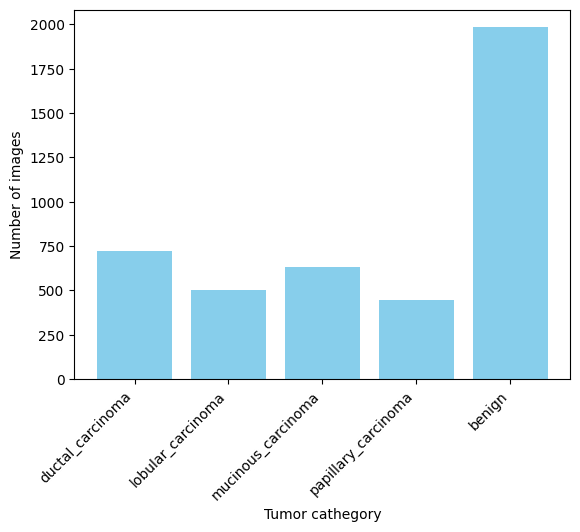

In [ ]:
dim_classes = [720, 501, 634, 448, 1984]
plt.bar(['ductal_carcinoma', 'lobular_carcinoma','mucinous_carcinoma', 'papillary_carcinoma', 'benign'], dim_classes, color='skyblue')
plt.xlabel('Tumor cathegory')
plt.ylabel('Number of images')
plt.xticks(rotation=45, ha='right')
plt.show()

For the model implementation, check the notebooks **AlexNet** and **GoogLeNet**